In [7]:
import numpy as np
import pandas as pd 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
df=pd.read_csv("tested.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [8]:
df.drop(columns=["PassengerId","Name","Ticket","Cabin"],inplace=True)

In [49]:
df.head()
# df.isnull().sum()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,34.5,0,0,7.8292,Q
1,1,3,female,47.0,1,0,7.0000,S
2,0,2,male,62.0,0,0,9.6875,Q
3,0,3,male,27.0,0,0,8.6625,S
4,1,3,female,22.0,1,1,12.2875,S


In [218]:
X=df.iloc[:,1:8]
Y=df.iloc[:,0]
from sklearn.model_selection import train_test_split
[X_train,X_test,Y_train,Y_test]=train_test_split(X,Y)

In [27]:
imputer=SimpleImputer()
X_train_age=imputer.fit_transform(X_train[["Age","Fare"]])
X_test_age=imputer.transform(X_test[["Age","Fare"]])
# X_train_age=pd.DataFrame(X_train_age)
# X_train_age.isnull().sum()

0    0
1    0
dtype: int64

In [89]:
encoder=OneHotEncoder(handle_unknown="ignore")
X_train_new=encoder.fit_transform(X_train[["Sex","Embarked"]]).toarray()
X_test_new=encoder.transform(X_test[["Sex","Embarked"]]).toarray()
np.hstack((X_train[["Pclass","Age","SibSp","Parch","Fare"]].values,X_train_new))
np.hstack((X_test[["Pclass","Age","SibSp","Parch","Fare"]].values,X_test_new))

array([[ 3., 23.,  0., ...,  0.,  0.,  1.],
       [ 3., 35.,  0., ...,  0.,  1.,  0.],
       [ 2., 30.,  1., ...,  0.,  0.,  1.],
       ...,
       [ 1., 17.,  0., ...,  0.,  0.,  1.],
       [ 3., 24.,  0., ...,  0.,  1.,  0.],
       [ 2., nan,  0., ...,  1.,  0.,  0.]])

In [95]:
X_train_new2=X_train.drop(columns=["Age","Fare","Sex","Embarked"])
X_train_transformed=np.concatenate((X_train_new2,X_train_age,X_train_new),axis=1)
X_test_new2=X_test.drop(columns=["Age","Fare","Sex","Embarked"])
X_test_transformed=np.concatenate((X_test_new2,X_test_age,X_test_new),axis=1)

In [115]:
#if there would have been missing values in embarked,apply simple imputer only but mention strategy="most frequent" in the argument
#if there would have been missing values in embarked,we would make another object for it as even after filling the missing values the reault is stored in a different array
clf=DecisionTreeClassifier()
clf.fit(X_train_transformed,Y_train)
Y_pred=clf.predict(X_test_transformed)
from sklearn.metrics import accuracy_score
accuracy_score(Y_pred,Y_test)

1.0

In [121]:
import pickle
import os

# Create 'models' directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

# Saving the model
pickle.dump(clf, open("models/clf.pkl", "wb"))

# Saving the encoder
pickle.dump(encoder, open("models/encoder.pkl", "wb"))



<h2>Pipelining</h2>

In [302]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.feature_selection import SelectKBest,chi2
df=pd.read_csv("tested.csv")
df.drop(columns=["PassengerId","Name","Ticket","Cabin"],inplace=True)
X=df.iloc[:,1:8]
Y=df.iloc[:,0]
[X_train,X_test,Y_train,Y_test]=train_test_split(X,Y)
tnf1=ColumnTransformer([("tnf1",SimpleImputer(strategy="mean"),[2,5])],remainder="passthrough")
tnf2=ColumnTransformer([("tnf2",OneHotEncoder(handle_unknown="ignore",sparse_output=False),[1,6])],remainder="passthrough")
tnf3=ColumnTransformer([("tnf3",MinMaxScaler(),slice(0,6))])
tnf4=SelectKBest(score_func=chi2,k=5)
tnf5=DecisionTreeClassifier()
pipe=Pipeline([("tnf1",tnf1),("tnf2",tnf2),("tnf3",tnf3),("tnf4",tnf4),("tnf5",tnf5)])
pipe.fit(X_train,Y_train)
Y_pred=pipe.predict(X_test)
import pickle 
pickle.dump(pipe,open("models/pipe.pkl","wb"))
pipe.named_steps["tnf1"].transformers_[0][1].statistics_   #we can extract info from pipe like this 
from sklearn.metrics import accuracy_score 
accuracy_score(Y_pred,Y_test)
from sklearn.model_selection import cross_val_score #cross validation
cross_val_score(pipe,X_train,Y_train,cv=5,scoring="accuracy").mean()

0.6325652841781874

C:\Users\Shreya Sharma\AppData\Local\Temp\ipykernel_21300\1917262053.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_train_scaled["Age"],hist=False)
C:\Users\Shreya Sharma\AppData\Local\Temp\ipykernel_21300\1917262053.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_

<Axes: xlabel='Fare', ylabel='Density'>

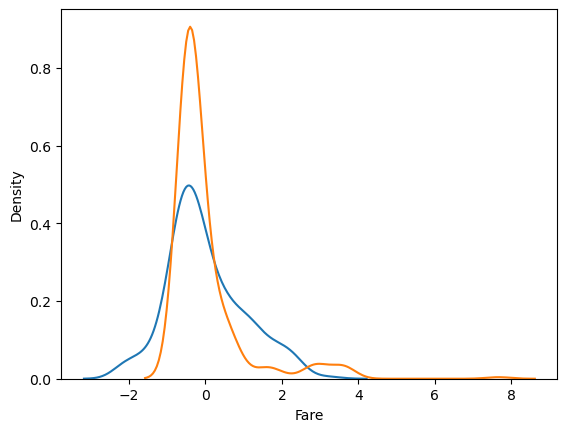

In [354]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train[["Age","Fare"]])
X_train_scaled=pd.DataFrame(X_train_scaled)
X_train_scaled.columns=["Age","Fare"]
np.round(X_train_scaled.describe(),1)
import seaborn as sns 
sns.distplot(X_train_scaled["Age"],hist=False)
sns.distplot(X_train_scaled["Fare"],hist=False)